> ## Parallelism/Optimization
> This code is optmized with core multiprocessing. On variable **USE_MULTIPROCESSING** set the maximum number of parallel operations that the program can run.  
> If you don't use it, set `USE_MULTIPROCESSING = 0`

In [1]:
import psutil
USE_MULTIPROCESSING = psutil.cpu_count()

print('Using ' + str(USE_MULTIPROCESSING) + ' parallel tasks')

Using 4 parallel tasks


> ## Library imports

In [2]:
import os, shutil
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
if os.path.isdir("__pycache__"):
    shutil.rmtree("__pycache__")

# Our code
from modules.balance_dataset import input_output
from modules.evaluation import fitness
from modules.utils import results_folder
from modules import visualize
from modules import operator_set

import operator

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp
from deap import tools

from modules.statistics import runtime_metrics
import time
import numpy as np
import math
import random

import pandas as pd

if USE_MULTIPROCESSING > 0:
    import multiprocessing as mp
    from multiprocessing import Pool

> ## Files
> Set the folder where files are on **DATASET_FOLDER**.  
> Specify the data files you want to use on **FILE_LIST**.
>  
> ### File format
> The files must be on csv format without header. One of the columns must be the label column
>   
> ### Example
> The following files are the same data used on our GECCO 2019 paper. The csv files contain the preprocessed data from [DREAMS project](http://www.tcts.fpms.ac.be/~devuyst/Databases/DatabaseSpindles/). Each file represent an patient and each row contain the 75 initial extracted features from an 2 s signal segment.  
> The two last columns are the data labels. Column 75 indicates with the label '1' the samples which both specialist agreed that are spindles. Column 76 indicates with the label '1' any sample marked as spindle

In [3]:
DATASET_FOLDER = 'modules/data/2000ms'
FILE_LIST = ['wav75_ex2_.csv','wav75_ex3_.csv','wav75_ex4_.csv','wav75_ex5_.csv','wav75_ex6_.csv','wav75_ex7_.csv','wav75_ex8_.csv']

> ## Importing data

In [4]:
data = input_output.read_dataset_list(DATASET_FOLDER, FILE_LIST)
X_train, y_train, X_test, y_test = input_output.balance_dataset(data, data_columns = list(range(0,75)), label_column = 75, test_size = 0)


# I am using patient 1 as test data
df = pd.read_csv('modules/data/2000ms/wav75_ex1_.csv', header = None)
X_test = df[df.columns[0:75]].values
y_test = df[df.columns[76]].values

# One hot vector
y_train = np.array([[x, int(not x)] for x in y_train])
y_test  = np.array([[x, int(not x)] for x in y_test])
n_att = 75

> ## Evaluation metric
> Our *fitness* function optimize one or more classification metrics. On **opt_vars**, select those metrics.
> Options:
> - **acc**: Accuracy
> - **auc**: AUC Score
> - **prec_S**: Precision (Spindles as class 1)
> - **prec_NS**: Precision (Not spindles as class 1)
> - **rec_NS**: Recall (Not Spindles as class 1)
> - **rec_S**: Recall (Spindles as class 1)
> - **f1_NS**: F1 Score (Not Spindles as class 1)
> - **f1_S**: F1 Score (Spindles as class 1)
> - **TN**: True Negatives Number
> - **FP**: False Positives Number
> - **TP**: True Positives Number
> - **FN**: False Negatives Number
>  
> On **wts_vars**, create a tuple with each metric weight. Positive weights mean that the GP will try to maximize the metric. For the negative ones, GP will try to minimize.  
> Example:  
> `opt_vars = ['FP', 'TP']`    
> `wts_vars = tuple([-1, 2])`

In [5]:
opt_vars = ['f1_S']
wts_vars = tuple([1])
eval_func = fitness.eval_function(opt_vars)
'''
    Result: eval_func -> auc = lambda(y_true, y_pred)

    Anothe example:
        eval_func = fitness.eval_function(['auc', 'acc'])
        Result: eval_func -> auc, acc = lambda(y_true, y_pred)
'''
'''
    Multiparameter optimization
    opt_vars -> evaluation metrics
    wts_vars -> tuple with each metric weight
    
    Example: Optimizing False positives and True positives
    opt_vars = [FP, TP]
    wts_vars = tuple([-1, 2])
    
    It means that we want to reduce False positives and maximize True positives. And it is more 
    important to have True positives, because we have set its weight higher.
'''
for v, w in zip(opt_vars, list(wts_vars)):
    if w > 0:
        print('Maximizing (' + v + ') with weight (' + str(w) + ')')
    else:
        print('Minimizing (' + v + ') with weight (' + str(-1*w) + ')')


Maximizing (f1_S) with weight (1)


> ## Target Classifier   
> Our aproach create features that improves a classifier performance. In this code, we set 5 default classifiers (set on variable):
> - nb: Naive Bayes  
> - dt: Decision Tree  
> - mlp: Multilayer Perceptron  
> - knn: K Nearest Neighbors  
> - svm: Support Vector Machine  
> - kmeans: K-means Clustering (Using each cluster as a class of the problem)  
>  
> If you want to use them, it is necessary to set their parameters:
> - nb: \[None, None\]
> - dt: \[None, None\]
> - mlp: \[first hidden layer size,activation function\]
> - knn: \[K, None\]
> - svm: \[None,kernel\]
> - kmeans: \[K, None\]
>  
> Example:  
> `classifier = 'svm'`   
> `clf_param = [None, 'rbf']`  
> `external = False`
>  
> ### Using a different classifier   
> If you want to use a different classifier, it needs the following methods (like scikit-learn):
> - fit(X,y): Trains the classifier
> - predict(X): Returns a predict label array given the data X
> - predict_proba(X): Return the predictiom probability for each sample in X
>   
> Example:  
> `from sklearn.ensemble import RandomForestClassifier`  
> `classifier = 'rf'`  
> `external = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)`

In [6]:
classifier = 'nb'
external = False
clf_param = [None,None] 
'''
    options:
        nb: Naive Bayes; params: None
        dt: Decision Tree; params: None
        mlp: Multilayer Perceptron; params: [first hidden layer size,activation function]
        knn: K Nearest Neighbors; params: [K,-1]
        svm: Support Vector Machine; params: [-1,kernel]
        kmeans: K-means Clustering (Using each cluster as a class of the problem); params: [number of clusters, -1]
        external: Default = False. You can use any classifier, but the following methods (like scikit-learn):
            fit(X, y)
            predict(X)
            predict_proba(X)

    Example 1:
    from sklearn.ensemble import RandomForestClassifier
    classifier = 'rf'
    external = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)
    
    Example 2:
    classifier = 'nb'
    external = False
    
    Example 3:
    classifier = 'svm'
    clf_param = [None, 'rbf']
    external = False
'''
print('Using ' + classifier + ' classifier')

Using nb classifier


> ## GP operator set
> As described on our paper, we have set protected operators for division, log and square root to avoid math domain problems.  
> Check it on **modules/operator_set**

In [7]:
pset = gp.PrimitiveSet("MAIN", n_att)
pset.addPrimitive(operator.add, 2)
pset.addPrimitive(operator.sub, 2)
pset.addPrimitive(operator.mul, 2)
pset.addPrimitive(operator_set.plog, 1)
pset.addPrimitive(operator_set.psqrt, 1)
pset.addPrimitive(operator_set.pdiv, 2)
pset.addPrimitive(operator_set.F, 1)
# pset.addPrimitive(math.sin, 1)
# pset.addPrimitive(math.cos, 1)
# pset.addPrimitive(operator.neg, 1)

> ## GP parameters  
> Set here:  
> - Population size  
> - Number of generations  
> - Crossover type and probability  
> - Mutation type and probability  
> - Individual initialization and selection
>  
>  Se more parameters types on [DEAP documentation](https://deap.readthedocs.io/en/0.7-0/api/tools.html)

In [8]:
# Population size
NPOP = 100

# Number of generations
NGEN = 50

# Crossover probability
CXPB = .85

# Mutation probability
MUTPB = .15

creator.create("FitnessMulti", base.Fitness, weights = wts_vars)
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMulti)

toolbox = base.Toolbox()
# Individual and population
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=3)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)

# Evaluation method
toolbox.register("evaluate", fitness.eval_tree, clf = classifier, X_train = X_train, y_train = y_train, X_test = X_test, y_true = y_test, pset = pset, opt_vars = opt_vars, eval_func = eval_func, param = clf_param, external = external)

# Initialization
# toolbox.register("expr_init", gp.genFull, min_=4, max_=7)
# toolbox.register("expr_init", gp.genGrow, min_=4, max_=7)
toolbox.register("expr_init", gp.genHalfAndHalf, min_=4, max_=7)

# Selection
toolbox.register("select", tools.selTournament, tournsize=3)
# toolbox.register("select", tools.selRoulette)
# toolbox.register("select", tools.selRandom)

# Crossover
toolbox.register("mate", gp.cxOnePoint)
# toolbox.register("mate", gp.cxTwoPoint)
# toolbox.register("mate", gp.cxcxOnePointLeafBiased, termpb =.1)

# Mutation
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_init, pset=pset)
# toolbox.register("mutate", gp.mutNodeReplacement, pset=pset)
# toolbox.register("mutate", gp.mutInsert, pset=pset)
# toolbox.register("mutate", gp.mutShrink)toolbox.register("mutate", gp.mutEphemeral, mode = 'all')

> ## Bloat Control
> We have used an simple bloat control limiting the maximum individual tree heigth.  
> Set it on **TAM_MAX**. If you have low computational resources, we recommend **TAM_MAX** < 20 


In [9]:
# Bloat Control
TAM_MAX = 10
toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value = TAM_MAX))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value = TAM_MAX))

> ## Create population 0

In [10]:
start = time.time()

pop = toolbox.population(NPOP)

# Much faster!
if USE_MULTIPROCESSING > 0:
    def ff(ind):
        fit = fitness.eval_tree(ind, clf = classifier, X_train = X_train, y_train = y_train, X_test = X_test, y_true = y_test, pset = pset, opt_vars = opt_vars, eval_func = eval_func, param = clf_param, external = external)
        if (math.isnan(fit[0])):
            ind.fitness.values = 0,
        else:
            ind.fitness.values = fit
        return ind

    def fmate(children):
        if random.random() < CXPB:
            children = toolbox.mate(children[0], children[1])
            del children[0].fitness.values
            del children[1].fitness.values
        return children[0], children[1]
    
    def fmutate(mutant):
        if random.random() < MUTPB:
            mutant = toolbox.mutate(mutant)[0]
            del mutant.fitness.values
        return mutant
    
    # t1 = time.time()
    p = Pool(USE_MULTIPROCESSING)
    pop = p.map(ff, pop)
    # t2 = time.time()
      
else:
    # t3 = time.time()
    fitnesses = list(map(toolbox.evaluate, pop))
    
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
        if (math.isnan(fit[0])):
            ind.fitness.values = 0,
        else:
            ind.fitness.values = fit
    # t4 = time.time()

> ## Runtime metrics

In [11]:
mstats = runtime_metrics.init_stats()
log = tools.Logbook()
hof = tools.selBest(pop, 1)

# Execution number (identifier)
NEXEC = 1

# Just an exibition function on terminal
def printProgressBar (iteration, total, prefix = '', suffix = '', decimals = 1, length = 100, fill = '|'):
    """
    Call in a loop to create terminal progress bar
    @params:
        iteration   - Required  : current iteration (Int)
        total       - Required  : total iterations (Int)
        prefix      - Optional  : prefix string (Str)
        suffix      - Optional  : suffix string (Str)
        decimals    - Optional  : positive number of decimals in percent complete (Int)
        length      - Optional  : character length of bar (Int)
        fill        - Optional  : bar fill character (Str)
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filledLength = int(length * iteration // total)
    bar = fill * filledLength + '-' * (length - filledLength)
    print('\r%s |%s| %s%% %s' % (prefix, bar, percent, suffix), end = '\r')
    # Print New Line on Complete
    if iteration == total: 
        print()

> ## Final settings
> Select the verbosity level:  
> - `verb = 0`: Nothing
> - `verb = 1`: Progress bar
> - `verb = 2`: Runtime statistics for each generation

In [12]:
# Verbosity level
verb = 1

# Results folder
path = 'result_GP_' + str(NEXEC) + '/'
results_folder.verify_create_dir(path)

# Log files prefix
filename = 'GP_'+ classifier + '_' + 'NEXEC'
balance = 1

> ## GP starts

In [13]:
if verb >= 1:
    print(">> (Exec " + str(NEXEC) + ") GP + " + classifier + " - Feature Selection and Construction")
    print(">> NGEN = " + str(NGEN) + " | NPOP = " + str(NPOP) + " | MAX_DEPTH = " + str(TAM_MAX) + " | PARAM = " + str(clf_param))
    print(">> Optimizing: " + str(opt_vars))
    print(">> Weights:    " + str(wts_vars))
    # if verb == 1:
    #    sys.stdout.write("[%s]" % (" " * toolbar_width))
    #    sys.stdout.flush()
    #    sys.stdout.write("\b" * (toolbar_width+1))
    
if verb == 1:
    printProgressBar(0, NGEN, prefix = '>> Progress:', suffix = 'Complete', length = 50)

for g in range(NGEN):
    geninit = time.time()
    
    if verb == 1:
        printProgressBar(g + 1, NGEN, prefix = '>> Progress:', suffix = 'Complete', length = 50)

    pop = toolbox.select(pop, NPOP)

    if USE_MULTIPROCESSING > 0:
        offspring = list(map(toolbox.clone, pop))
        offspring = p.map(fmate, list(zip(offspring[::2], offspring[1::2])))
        offspring = [xx for sub in offspring for xx in sub]
        offspring = p.map(fmutate, offspring)
        offspring = p.map(ff, offspring)
    else:
        offspring = algorithms.varAnd(pop, toolbox, CXPB, MUTPB)
        fitnesses = list(map(toolbox.evaluate, offspring))

        for ind, fit in zip(offspring, fitnesses):
            ind.fitness.values = fit
            if (math.isnan(fit[0])):
                ind.fitness.values = 0,
            else:
                ind.fitness.values = fit

    hof = tools.selBest(pop, 1)

    pop[:] = offspring + hof
    log.record(gen = g, time = round(time.time() - geninit, 2),**mstats.compile(pop))

    if verb == 2:
        print(log.stream)

end = time.time()

total_time = end - start

if verb >= 1:
    if total_time < 60:
        print("\n>> End (" + str(round(total_time)) + " seconds)\n")
    elif total_time < 3600:
        print("\n>> End (" + str(round(total_time/60)) + " minutes)\n")
    else:
        print("\n>> End (" + str(math.floor(total_time/3600)) + " hours and " + str(round(abs(math.floor(total_time/3600)-total_time/3600)*60)) + " minutes)\n")

logfile = open(os.path.join(path, "log/LOG_" + filename + "_" + str(NEXEC) + ".csv"), 'w')
logfile.write(str(log))
logfile.close()

prf, acc, cfm, AUC = fitness.performance(hof[0], classifier, X_train, y_train, X_test, y_test, pset, clf_param, external)

info_file_name = os.path.join(path,"infoGP.csv")
infoGP = open(info_file_name, 'a')
if os.stat(info_file_name).st_size == 0:
    infoGP.write("balance,DEEP MAX,classifier,P1,P2,#Exec,PPV_S,PPV_NS,TPR_S,TPR_NS,F1_S,F1_NS,SUP_S,SUP_NS,TN,FP,FN,TP,Acc,AUC,Deep,Training Time\n")

infoGP.write(str(balance) + ',' + str(TAM_MAX) + ',' + classifier + ',' + str(clf_param[0]) + ',' + str(clf_param[1]) + ',' +  str(NEXEC) + ',' + str(prf[0][0]) + ',' 
        + str(prf[0][1]) + ',' + str(prf[1][0]) + ',' + str(prf[1][1]) + ',' + str(prf[2][0]) + ',' 
        + str(prf[2][1]) + ',' + str(prf[3][0]) + ',' + str(prf[3][1]) + ',' 
        + str(cfm[0]) + ',' + str(cfm[1]) + ',' + str(cfm[2]) + ',' + str(cfm[3]) + ',' 
        + str(acc) + ',' + str(AUC) + ',' + str(hof[0].height) + ',' + str(total_time) + '\n')

infoGP.close()

tree = gp.PrimitiveTree(hof[0])
expFILE = open(path + "best_expr/EXPR_" + filename + "_" +  str(NEXEC) + ".txt", 'w')
expFILE.write(str(tree))
expFILE.close()

>> (Exec 1) GP + nb - Feature Selection and Construction
>> NGEN = 50 | NPOP = 100 | MAX_DEPTH = 10 | PARAM = [None, None]
>> Optimizing: ['f1_S']
>> Weights:    (1,)
>> Progress: |||||||||||||||||||||||||||||||||||||||||||||||||||| 100.0% Complete

>> End (1 minutes)



> ## Visualize the best feature set created

In [14]:
features = list(set(visualize.get_equations_simplified(hof[0])))
print(str(len(features)) + ' features')
for i in list(range(len(features))):
    print('Feature ' + str(i) + ': ' + str(features[i]))

6 features
Feature 0: ARG11*ARG20
Feature 1: ARG16
Feature 2: ARG11
Feature 3: ARG6
Feature 4: ARG20*ARG9
Feature 5: ARG13


> ## Detailed performance

In [15]:
prf, acc, cfm, AUC = fitness.performance(hof[0], classifier, X_train, y_train, X_test, y_test, pset, clf_param, external)
print('Precision: ', round(prf[0][0], 4))
print('Recall   : ', round(prf[1][0], 4))
print('F1-Score : ', round(prf[2][0], 4))
print('Accuracy : ', round(acc, 4))
print('AUC      : ', round(AUC, 4))
print('Confusion Matrix: ')
print(' \t0   \t1   ')
print('0\t'+str(cfm[0])+'\t'+str(cfm[1]))
print('1\t'+str(cfm[2])+'\t'+str(cfm[3]))

Precision:  0.6419
Recall   :  0.738
F1-Score :  0.6866
Accuracy :  0.86
AUC      :  0.815
Confusion Matrix: 
 	0   	1   
0	636	77
1	49	138


> ## Final GP tree
If the plot appears wierd, please run this instruction twice

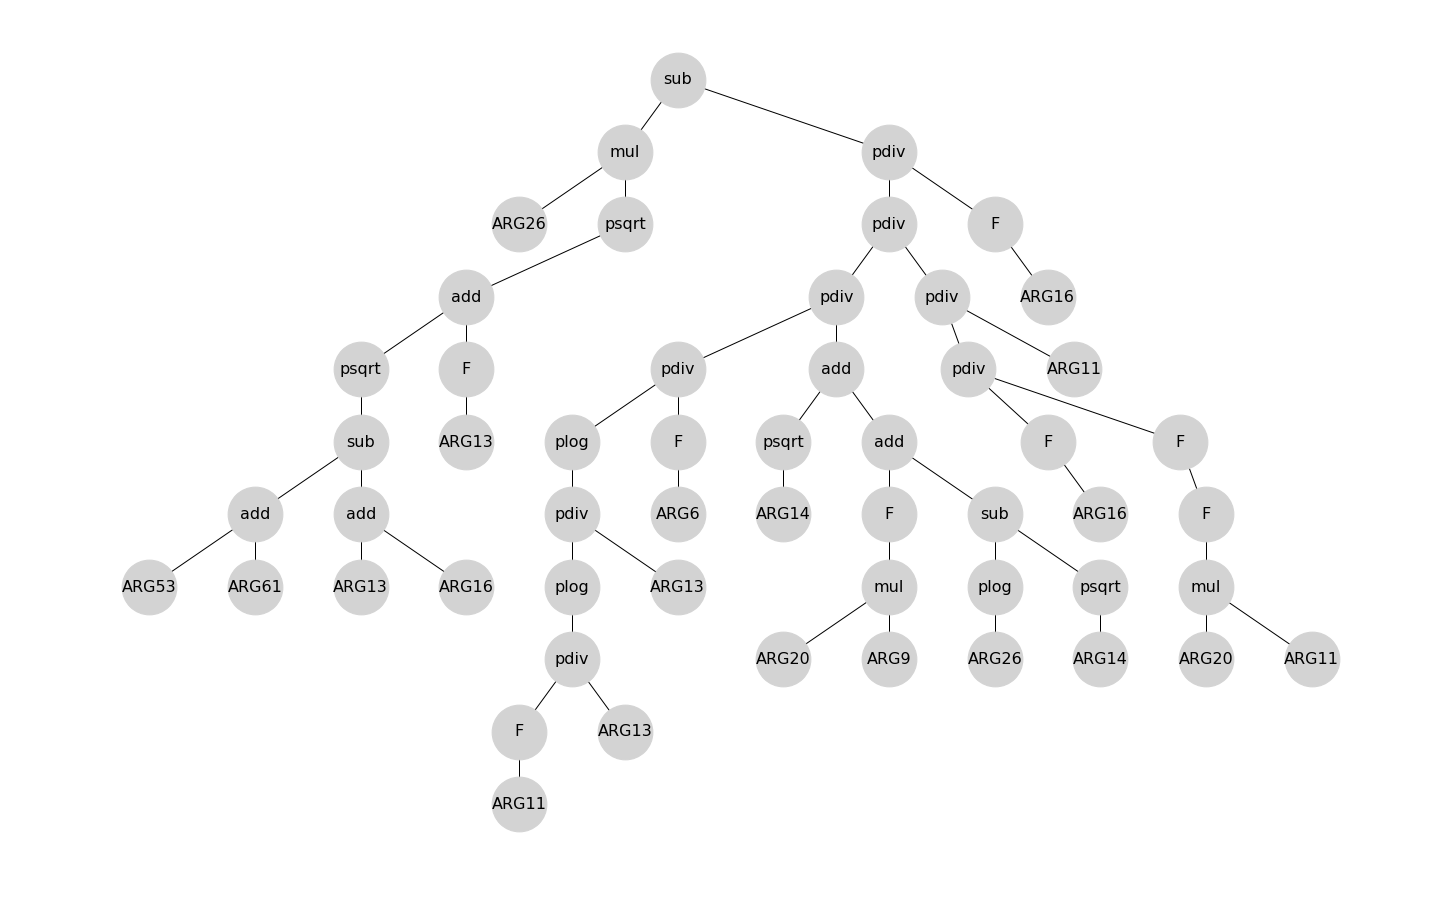

In [17]:
visualize.plot_tree(hof[0], path = path + "best_expr/EXPR_" + filename + "_" +  str(NEXEC) + ".pdf")

> ## Conclusion
> Check the results folder:  
> Runtime information at **results_GP_1/log**  
> The best feature set and the tree plot at **results_GP_1/best_expr**  
> The best feature set at **results_GP_1/infoGP.csv**